# Machine Learning Lab 4: Mini Project 2

In mini-project 2, you'll be employing machine learning techniques, such as **Linear Probability Models (LPM)** or **k-Nearest Neighbors (KNN)**, to improve the government's ability to identify tax-evading firms. By analyzing characteristics common among tax-evading firms, the government can predict tax evasion with lower error rates, enhancing the effectiveness of targeted audits. 

### Today's Lab: KNN

Today, we will be working with a dataset that looks at physico-chemical and sensorial characteristics of Red Wine. The data were taken from the [UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/wine+quality)

The *rows* are samples of red wine. Each wine sample has the following characteristics (*columns*):

* Fixed acidity
* Volatile acidity
* Citric acid
* Residual sugar
* Chlorides
* Free sulfur dioxide
* Total sulfur dioxide
* Density
* pH
* Sulphates
* Alcohol
* Quality (score between 0 and 10)

We will use these characteristics or "features" to predict the quality of wine using a **KNN model**.

**In this Lab we will**
* Read in and explore the wine dataset
* Perform basic data pre-processing and create a test/train split
* Build a KNN model and explore different values of k
* Implement Cross-Validation to find the best K
* Plot the ROC curve and calculate AUC
* Experiment with different cost functions


**After today's lab you should be**
* Comfortable implementing a KNN model with scikit learn
* Comfortable implementing k-fold cross validation to select k.
* Understand how to interpret an ROC curve and the AUC
* Comfortable interpreting the results of a confusion matrix and explain why you might choose different performance metrics depending on the goal of your prediction task

# Preparing for Analysis

### Part 1: Load and Explore Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

##### Load Data from CSV

NOTE: In the CSV file, you'll notice that the columns are actually separated by semi-colons (not commas), so we'll need to include that when we call pd.read_csv().

In [2]:
wine_data = pd.read_csv('winequality-red.csv', sep=';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##### Distribution of the Target Class

We start by looking at the distribution of the target class. If the distribution of the target class is imbalanced (i.e., some classes are overrepresented while others are underrepresented or if the data is skewed), it can lead to models that are biased towards the more frequent classes. 

In [3]:
print(wine_data.groupby("quality").size())


quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64


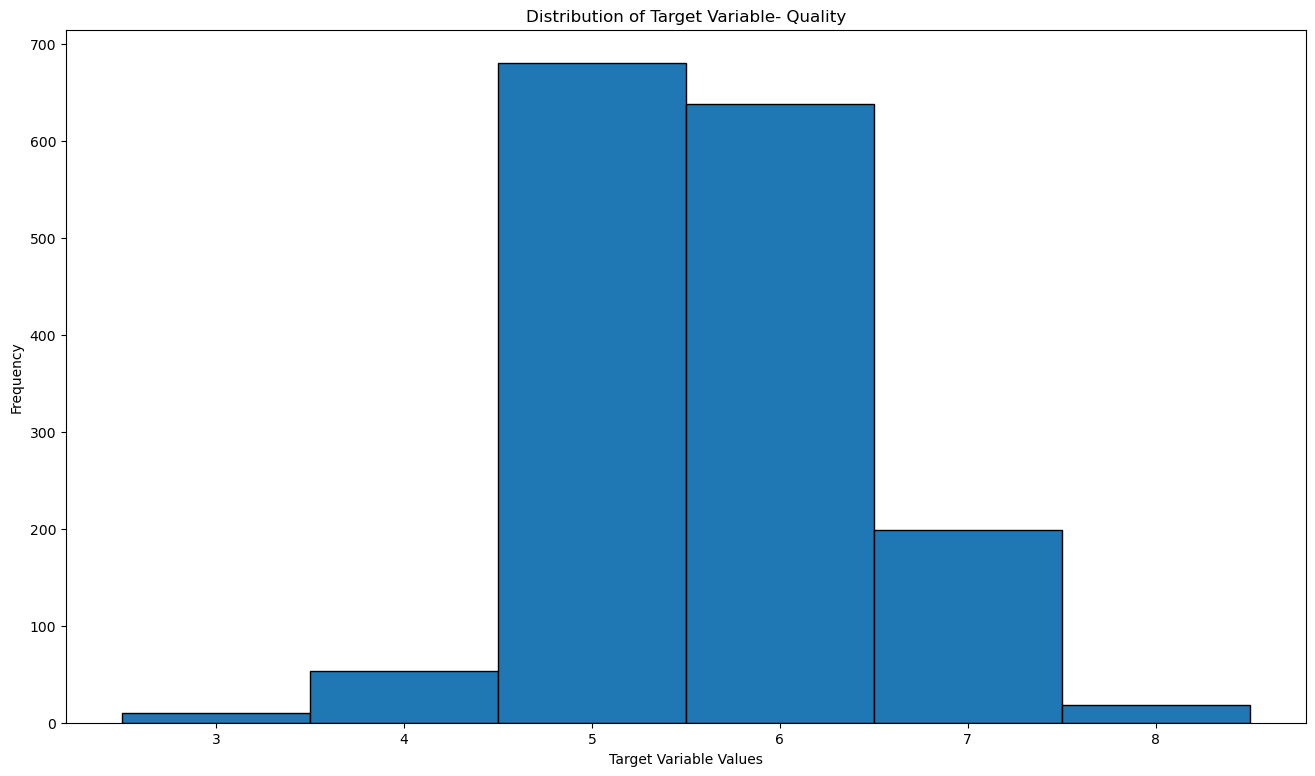

In [4]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(wine_data['quality'], bins=[2.5, 3.5,4.5, 5.5, 6.5,7.5,8.5], edgecolor='black', alpha=1)
ax.set_xticks([3, 4, 5, 6, 7, 8])
ax.set_title('Distribution of Target Variable- Quality')
ax.set_xlabel('Target Variable Values')
ax.set_ylabel('Frequency')
plt.show()

##### Check for missing values

In [5]:
## wine_data.isna() gives us a pandas df of the same shape where each entry is True if it's a missing value and 
## False if it isn't. Recall that np.sum assigns 1 to True and 0 to False. 
## axis = 0 means we're summing within each column. 
na_count = pd.DataFrame(np.sum(wine_data.isna(), axis = 0), columns = ["Count NAs"])
na_count

,Count NAs
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


##### Descriptive Statistics

In [6]:
pd.set_option('display.max_columns', None) # no column will be hidden in output
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Part 2: Pre-processing 

##### Splitting Data

In [7]:
X = wine_data.drop(columns = ['quality'])
target = wine_data.loc[:,'quality']
display(X.head())
display(target.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

##### Check Data Types

The type of data will determine how you scale/normalize.

In [8]:
X.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

All of the data are floats so we can use the standard scalar which works by:

* Centering the Data: The process ensures that each feature has a mean of 0.

* Normalizing the Scale: Scales the data so that the features have a standard deviation of 1. 

*Why might be want to scale our values before model building?*

##### Scale Data

In [9]:
scaler = StandardScaler()  # Initialize the scalar
X_scaled = scaler.fit_transform(X)  
print(type(X_scaled))  # Scaled data is returned as a numpy array; can’t pass this directly into test_train_split 
cols = X.columns  #  The array retains the same column order as the df, so extract the col names from X
X_final = pd.DataFrame(X_scaled, columns=cols)  # Convert X_scaled to a df using the column names of X
X_final.head()

## If you wish to scale after splitting (which is what you normally want to be doing), you can:
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

<class 'numpy.ndarray'>


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


A note on scaling:

- **Scaling Before Splitting:** If you scale before splitting the data into training and validation sets, you are using the entire dataset to calculate the mean and variance used for scaling. This provides the most precise estimates of the population parameters. However, it also means that information from the validation (or test) set is being used, albeit indirectly, in the training process. This can lead to **data leakage**, where the model has some information about the validation set during training, which could inadvertently lead to overfitting.

- **Scaling After Splitting:** If you scale after splitting, you would calculate the mean and variance from the training set only and then apply this transformation to both the training and validation sets. This method prevents data leakage because the scaling factors are derived solely from the training data, ensuring that the validation set remains completely unseen by the model during training.

##### Recode `Quality`

We will record `quality` such as a binary variable such that it is good if quality is greater than 6 and bad otherwise.

In [10]:
target = pd.DataFrame(np.where(target > 5, 1, 0)).squeeze()
target.head()

0    0
1    0
2    0
3    1
4    0
Name: 0, dtype: int64

Let's look again at the target variable distribution:

In [11]:
target.value_counts()

1    855
0    744
Name: 0, dtype: int64

*What do we notice about the distribution of our target?*

##### Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_final, target, test_size=0.20, random_state=42)

*Why do we hold out a separate test set?*

# Creating and Tuning our Model

### Part 3: KNN

K-Nearest Neighbors (KNN) algorithm assumes that similar things exist in close proximity, i.e., "near things are more related than distant things." An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common k nearest neighbors.

EXAMPLE: When k=1, then the object is simply assigned to the class of that single nearest neighbor.

KNN allows us to specify several important parameters:

- **k:** The number of neighbors (required)
- **weights:** Votes weighted by distance?
    - Default is uniform weights. All points in each neighborhood are weighted equally.
    - Can also use distance, which weights points by the inverse of their distance. in this case, *closer neighbors of a query point will have a greater influence than neighbors which are further away.*
    - **metric:** Metric to use to compute the distance

##### Let's try with k = 1...

In [13]:
knn_1 = KNeighborsClassifier(n_neighbors = 1)
knn_1.fit(X_train, y_train)
knn_1_pred = knn_1.predict(X_test)
accuracy_score(y_test, knn_1_pred)

0.75625

##### Confusion Matrix where k = 1

In [17]:
## Notice that looking at the raw counts allows for direct computation of precision. 
cm_knn1 = confusion_matrix(y_test, knn_1_pred)
cm_knn1_norm = confusion_matrix(y_test, knn_1_pred, normalize = 'true')
print(cm_knn1)
print(cm_knn1_norm)


[[ 96  45]
 [ 33 146]]
[[0.68085106 0.31914894]
 [0.18435754 0.81564246]]


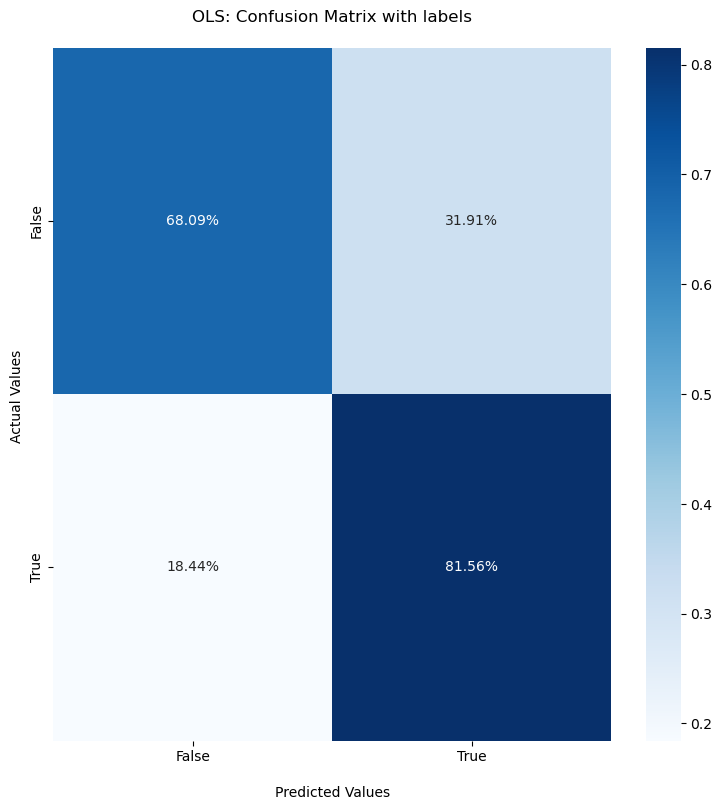

In [18]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(cm_knn1_norm, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Interpretation

- True Negatives (TN) - 60%  of actual negative instances correctly identified
- False Positives (FP) - 40% of all actual negative instances were incorrectly labeled as positive
- False Negatives (FN) - 233% actual positive instances were incorrectly labeled as negative
- True Positives (TP) - 67% of actual positive instances correctly identified


##### Now lets try with k = 20...

In [19]:
knn_11 = KNeighborsClassifier(n_neighbors = 20)
knn_11.fit(X_train, y_train)
knn_11_pred = knn_11.predict(X_test)
accuracy_score(y_test, knn_11_pred)

0.7

Accuracy is similar, but lets dig in a little deeper:

In [20]:
cm_knn11 = confusion_matrix(y_test, knn_11_pred)
cm_knn11_norm = confusion_matrix(y_test, knn_11_pred, normalize = 'true')
print(cm_knn11)
print(cm_knn11_norm)

[[ 97  44]
 [ 52 127]]
[[0.68794326 0.31205674]
 [0.29050279 0.70949721]]


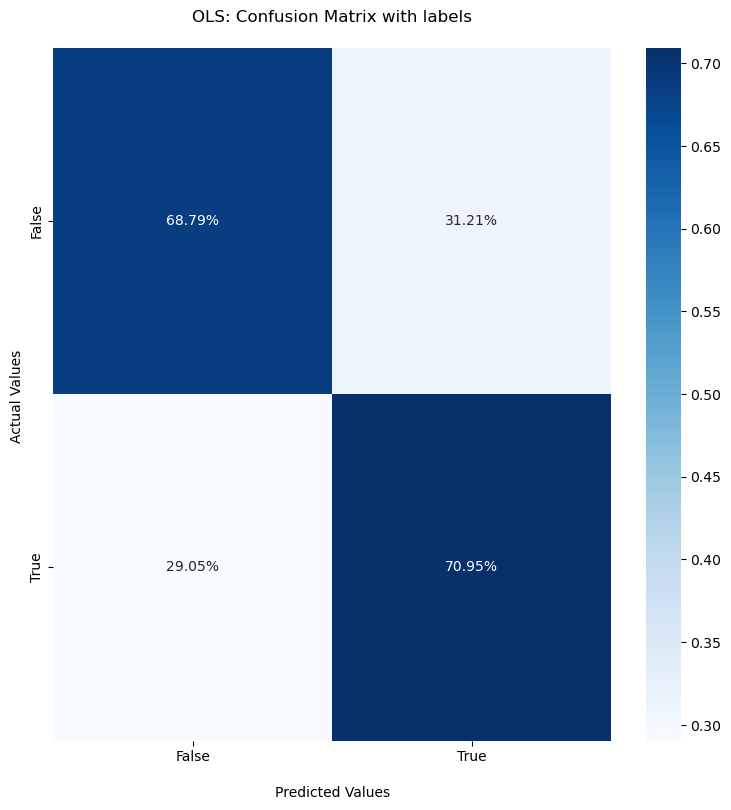

In [21]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(cm_knn11_norm, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

- True Negatives (TN) - 68%  of actual negative instances correctly identified
- False Positives (FP) - 37% of all actual negative instances that were incorrectly labeled as positive
- False Negatives (FN) - 31% actual positive instances that were incorrectly labeled as negative
- True Positives (TP) - 62% of actual positive instances correctly identified

#### Part 4: Finding the best k with cross-validation

Cross-validation is a great tool when selecting a model or setting its parameters. Essentially, by using the average accuracy from the folds, one makes sure that the model doesn't perform well just because of the train-test split.

The basic idea is to divide the dataset into K equally sized folds (subsets), and then the model is trained and evaluated K times, each time using a different fold as the test set and the remaining folds as the training set. This process helps to get a more robust estimate of the model's performance, reducing the impact of variability in a single train-test split. 

It's esentially like the model getting able to test a k number of times on "unseen" data. 


![CrossValidation.png](CrossValidation.png)

Choosing the correct value of k is important. If k is too small, we risk over-fitting and if k is too high, we risk under-fitting. k-fold cross-validation is one way to choose the optimal k.

**IMPORTANT: A note on shuffling**
- We need to include `shuffle = True` in our constructor
- When shuffle=True, data will be shuffled before being split into 5 different folds for the cross-validation process
- This shuffling ensures that the data in each fold is randomly sampled and does not depend on the order of the data as provided

In [26]:
# Select a range of KNN neighbors (k) to evaluate
# Rule of Thumb:  a good upper bound of k is roughly the square-root of the number of samples in our training set, but you should experiment based on what you find
# Rule of Thumb:  since the target class is selected by a majority vote, using odd values of k prevents ties & cuts initial computational costs in half 
ks = list(range(1, 37, 2))  
para = {'n_neighbors': ks}
print(para)

# Initialize the KNN classifier
knni = KNeighborsClassifier()

# Set up 5-fold cross-validation scheme
## GridSearch will allow us to search for the best performing neighborhood number.  
## knni tells GridSearch that we want to test KNN at various neighborhood numbers
## para tells GridSearch the set of neighborhood numbers we want to try out. 
## cv=kfcv tells GridSearch that we want cv as we specified via kfcv = KFold(5, random_state=42, shuffle=True).
kfcv = KFold(5, random_state=42, shuffle=True)
knn_cv = GridSearchCV(knni, para, cv=kfcv) 
# When shuffle=True in the KFold constructor, data will be shuffled before being split into 5 different folds for the cross-validation process

# Fit the model
## What is happening with knn_cv.fit(X_train, y_train)?
## (i) 5-fold cv as we've instructed
## (ii) across the neighborhood values we've chosen 
## (iii) and identifies the best performing neighborhood number. 
knn_cv.fit(X_train, y_train)
knn_cv_pred = knn_cv.predict(X_test)
knn_cv_pred_acc = accuracy_score(y_test, knn_cv_pred)

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)
print("Accuracy Score:", knn_cv_pred_acc)


{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]}
Best parameters: {'n_neighbors': 1}
Best cross-validation score: 0.736498161764706
Accuracy Score: 0.75625


# Evaluating Model Performance

### Part 5: ROC and AUC

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are popular statistical measures used in machine learning to *evaluate the performance of binary classification models*.

**ROC**

- The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). 
- Interpreting the slope of the ROC curve:
    - *Closer to the left-top corner:* Ideal. A curve that reaches towards the top left corner of the plot indicates a high TPR and a low FPR — the classifier is able to correctly identify most positives and has few false positives. This represents a high level of discrimination capability.
    - *Diagonal from (0,0) to (1,1):* This line represents the ROC curve of a random classifier (no better than random guessing). 
        - Any ROC curve that lies above the diagonal indicates a better-than-random classifier
        - Anything below suggests performance worse than random guessing

**AUC**

- A scalar value that summarizes the overall performance of the classifier.
    - An AUC of 0.5 suggests no discriminative ability (same as random guessing).
    - An AUC of 1.0 represents a perfect classifier.
    - An AUC less than 0.5 suggests worse than random predictions, but this is typically seen as a result of some error in modeling or data handling.

**Why not just use the confusion matrix?**

- Helpful for visualizing tradeoffs between increasing true positive and reducing false positives at different thresholds

#### Let's plot the ROC curve below and calculate the AUC, using the model with k = 1 neighbors which we selected by using k-fold cross validation.

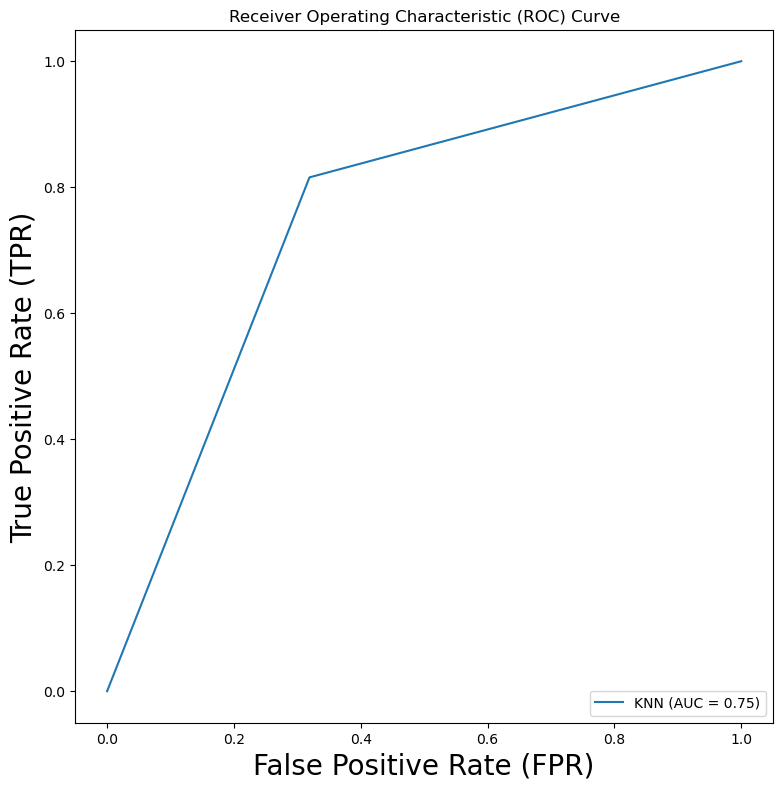

In [27]:
fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, knn_cv_pred)
auc_cv = roc_auc_score(y_test, knn_cv_pred)
roc_curve_cv = RocCurveDisplay(fpr=fpr_cv, tpr=tpr_cv, 
                                roc_auc=auc_cv,
                                estimator_name='KNN')


fig, ax = plt.subplots(figsize=(9, 9))
roc_curve_cv.plot(ax=ax)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=20)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=20)
ax.set_title("Receiver Operating Characteristic (ROC) Curve")
plt.show()


*What do you observe in this plot? How would you interpret the AUC?*

### Part 6: Changing the Performance Metric

#### Accuracy, Precision and Recall

Above, we used *accuracy* as our performance metric. **Accuracy** measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.

However, depending on the nature of our data and the goal of our task, we may want to evaluate our model on different metrics.

Let's say we are really concerned with not classifying bad wine as good wine. That is to say, we are most concerned with minimizing false positives.

For example, we might use **precision** instead of **accuracy**. Precision measures the proportion of true positive predictions in all positive predictions made by the model. High precision means that the model is reliable in its positive predictions.

In [29]:
## Recall creating a dictionary to store pairs of model and its performance from last week's lab. 
precision_scores = []

for i in ks:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    precision = precision_score(y_test, pred_i, zero_division=0)
    precision_scores.append(precision)

precision_scores = np.array(precision_scores)
max_precision = max(precision_scores)
opt_k_precision = ks[np.argmax(precision_scores)]

print("Optimal k for maximum precision:", opt_k_precision)
print("Maximum precision:", max_precision)


Optimal k for maximum precision: 29
Maximum precision: 0.7664670658682635


**Here is a summary of some common evaluation metrics:**

- **Accuracy:** Out of all predictions, how many did the model get right? (proportion of true results, both true positives and true negatives, among the total number of cases examined)

- **Precision:** Out of all the positive predictions made, how many are actually positive? (proportion of positive identifications that were actually correct)
    - Important in contexts where the cost of a false positive is high.

- **Recall:** Out of all the actual positives, how many did the model correctly identify as positive?
    - Important in contexts where the cost of a false negative is high.

- **F1 Score:** Balanced precision and recall

# Visualizing KNN

### Part 7: Visualizing KNN

We can visualize KNN to help understand what the model is doing. The first image below was created using drop data from last week's lab. 

What we notice: A clear decision boundary that generally maps to the patterns in the data, but does not overly conform to outliers

![KNN Plot Lab 4 Data](./output_lab4_data.png)

#### Now let's take a look using data from this week's lab. We choose two features so we can visualize in 2-D space

In [30]:
#If you don't have this 'mlxtend' library, you can install it with this command:
#!pip install mlxtend

#### First, let's plot when k = 1

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


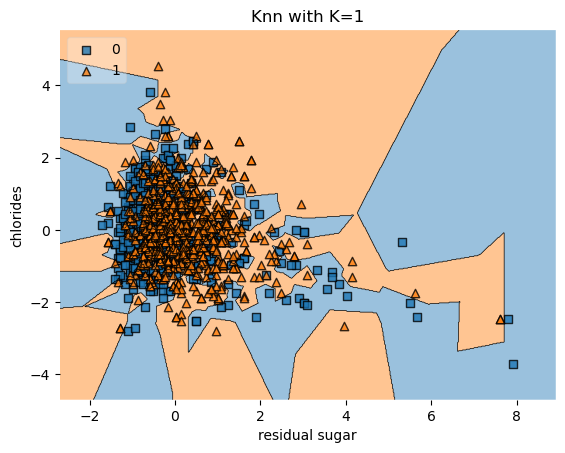

In [31]:
from mlxtend.plotting import plot_decision_regions

mini_X = X_train.loc[:,['sulphates', 'pH']]
y = y_train

def knn_comparison(k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(mini_X, y)
# Plotting decision region
    plot_decision_regions(np.array(mini_X), np.array(y), clf=knn_model, legend=2)
# Adding axes annotations
    plt.xlabel('residual sugar')
    plt.ylabel('chlorides')
    plt.title('Knn with K='+ str(k))
    plt.show()

knn_comparison(1)

#### Now, let's plot when k = 20

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


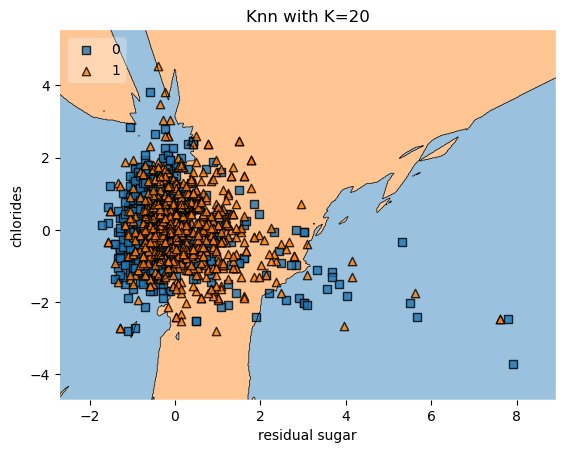

In [32]:
knn_comparison(20)

*Looking at the visualizations, is k = 1 more likely to be overfitting or underfitting? What about k = 20? Why?*

# Answers to Discussion Questions

- *Why might be want to scale our values before model building?*
    - all features are on the same scale
    - For algorithms that rely on distance calculations, such as k-nearest neighbors (KNN) and k-means clustering, features on larger scales can disproportionately influence the outcome
    - Scaling ensures that each feature has an equal chance of influencing the model's decisions.

- *What do we notice about the distribution of our target?*
    - Significant class imbalance

- *Why do we hold out a separate test set?*
    - Provides a more accurate measure of its real-world performance
    - Prevent over-fitting
    - unbiased evaluation of the model after you've selected the best model and tuned hyperparameters
    - fair comparison across different models

- *What do you observe in this plot? How would you interpret the AUC?*
    - **AUC Value:** The AUC is 0.64. This is above 0.5, which means the classifier is doing better than random chance, but it's not very close to 1.0. An AUC of 0.64 suggests moderate classification performance.

    - **Shape of the Curve:** The curve rises quickly at first, which indicates good capture of true positives for a low false positive rate when lower thresholds are used. However, the curve then proceeds increase more gradually, suggesting diminishing returns for the true positive rate as the false positive rate increases. The  classifier begins to struggle to increase the true positive rate without also increasing the false positive rate by a similar proportion.


